# Cuidado! Lluvia de Hamburguesas
## Análisis con arboles de decisión

### Integrantes
* Primerano Lomba, Franco Alejandro
* Montecalvo, Ignacio

### Configuraciones iniciales

In [1]:
import pandas as pd
import numpy as np
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from auxiliares import obtener_training_set
from auxiliares import obtener_valdev_set
from auxiliares import obtener_prediccion_set
from auxiliares import crear_archivo_predicciones
from auxiliares import plot_confusion_matrix
from auxiliares import plot_roc
from preprocessing import aplicarOneHot
from preprocessing import estandarizar

In [2]:
x,y = obtener_training_set()
x_val, y_val = obtener_valdev_set()
x = aplicarOneHot(x)
x_val = aplicarOneHot(x_val)

## Árboles de decisión

Decidimos empezar por ellos ya que entre los modelos de clasificación es uno sencillo y trivial, y suele dar una idea general o punto de referencia para comprar con modelos más complejos.

Estos árboles poseen nodos en los cuales se divide un conjunto de datos en dos grupos según los valores de cada instancia en un feature determinado. La clase asignada a las hojas del arbol es obtenida según algún criterio de maximización de ganancia o de minimización de impureza.

Los hiperparametros a definir son:

* Criterio: El criterio con el cual se determina la pureza de un nodo. Determinaremos el mejor entre gini y entropy
* Maxima profundidad: Es la longitud máxima que puede tener alguna rama partiendo de la raíz.
* Min Sample Leaf: Es la cantidad minima de instancias que debe tener un nodo para poder existir.

En primer lugar utilizaremos como preprocesamiento el transformar todas las variables categoricas con one hot encoding.
A partir de eso, se trabajará en un modelo estandarizado(al que se le resta el promedio a cada feature y se lo divide por el desvio estandar) y otro sin estandarizar. Ya sacamos un 10% de los datos para el hold-out con el cual verificaremos el mejor modelo que encontremos y con el resto haremos un 5-fold estratificado respetando el hecho de que porcentualmente el dia no target cubre casi un 80% de todos los datos.

Empezamos por el arbol sin estandarizar. Para cada ronda de k-fold buscaremos sus mejores parametros y obtendremos el accuracy promedio. Finalmente nos quedamos con los mejores parametros del mejor fold.

In [3]:
kf = StratifiedKFold(n_splits=5, random_state=119, shuffle=True)
arbol_uno = DecisionTreeClassifier()
arbol_uno = GridSearchCV(arbol_uno, {'criterion':('gini', 'entropy'), 'max_depth':[7,8,9,10,11,12,13,14], 'min_samples_leaf':[100,130,150,170,200]}, n_jobs = -1, cv = kf, scoring ='roc_auc')
arbol_uno.fit(x, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=119, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [7, 8, 9, 10, 11, 12, 13, 14],
                         'min_samples_leaf': [100, 130, 150, 170, 200]},
             scoring='roc_auc')

In [4]:
resultados = pd.DataFrame(arbol_uno.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_criterion','param_max_depth','param_min_samples_leaf','mean_test_score','mean_score_time' ]].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_score,mean_score_time
50,1,entropy,9,100,0.851528,0.057008
67,2,entropy,12,150,0.851515,0.054394
77,3,entropy,14,150,0.851440,0.064937
62,4,entropy,11,150,0.851409,0.060490
57,5,entropy,10,150,0.851378,0.056512


Ahora veamos el arbol con el dataset estandarizado

In [5]:
x_estandarizado = estandarizar(x.copy(), x.copy())
kf = StratifiedKFold(n_splits=5, random_state=119, shuffle=True)
arbol_dos = DecisionTreeClassifier()
arbol_dos = GridSearchCV(arbol_dos, {'criterion':('gini', 'entropy'), 'max_depth':[7,8,9,10,11,12,13,14], 'min_samples_leaf':[100,130,150,170,200]}, n_jobs = -1, cv = kf, scoring ='roc_auc')
arbol_dos.fit(x_estandarizado, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=119, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [7, 8, 9, 10, 11, 12, 13, 14],
                         'min_samples_leaf': [100, 130, 150, 170, 200]},
             scoring='roc_auc')

In [6]:
resultados = pd.DataFrame(arbol_dos.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_criterion','param_max_depth','param_min_samples_leaf','mean_test_score','mean_score_time' ]].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_score,mean_score_time
50,1,entropy,9,100,0.851548,0.054092
67,2,entropy,12,150,0.851536,0.055897
62,3,entropy,11,150,0.851449,0.056883
77,4,entropy,14,150,0.851441,0.056264
57,5,entropy,10,150,0.851406,0.058120


Se puede ver que consiguen un porcentaje bastance similar en cuanto a la certeza obtenida de ambos preprocesamientos. Para continuar utilizaremos el dataset sin estandarizar para mantener el preprocesamiento lo más simple posible, y utilizaremos los mejores parametros encontrados. Para ello utilizaremos la función best_estimator_ de sklearn

In [7]:
arbol_clasificador = arbol_uno.best_estimator_
arbol_clasificador.fit(x, y.values.ravel())

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=100)

### Visualizamos el arbol con los mejores hiperparametros obtenidos:

In [8]:
dot_data = tree.export_graphviz(arbol_clasificador, class_names=["Lloverán", "No lloverán"], feature_names=x.columns) 
graph = graphviz.Source(dot_data, format='png')
graph.render("Arbol")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.881805 to fit


'Arbol.png'

El arbol es muy grande para mostrarlo en el notebook pero lo dejaremos en el directorio. En el mismo se observa que los features más importantes corresponden con los descubiertos en la primera parte del trabajo práctico, siendo el más importante la humedad por la tarde. 

### Matriz de confusión



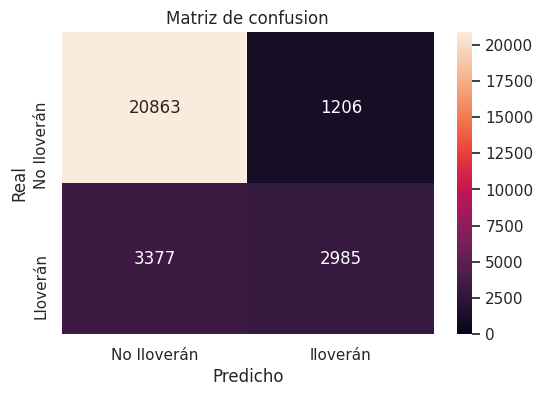

In [9]:
plot_confusion_matrix(y_val, arbol_clasificador.predict(x_val))

#### Accuracy

In [10]:
accuracy_score = accuracy_score(y_val,arbol_clasificador.predict(x_val))
print("ACCURACY SCORE: ",accuracy_score)

ACCURACY SCORE:  0.8388027153459252


Podemos observar que a pesar de tener un accuracy respetable, la matriz de confusión muestra mayor cantidad de false negatives que de true positives. Los true negatives son los más abundantes como es de esperar debido a la distribución del dataset.
* Del total de dias que lloverán en el dataset(6362), logró prededir solo 2985 de ellos(menos de la mitad).
* Del total de dias que no lloverán en el dataset(22069), logró prededir 20863 de ellos(casi la totalidad).
* Del total de predichos como que lloverán (4191), solo en 2985 de ellos realmente iba a llover al dia siguiente.

Utilizando las formulas correspondientes vemos que tiene una Precisión del 71% y un Recall del 47%. También tiene una especificidad del 94%.

Su F1 Score es de 0.56

### Curva ROC

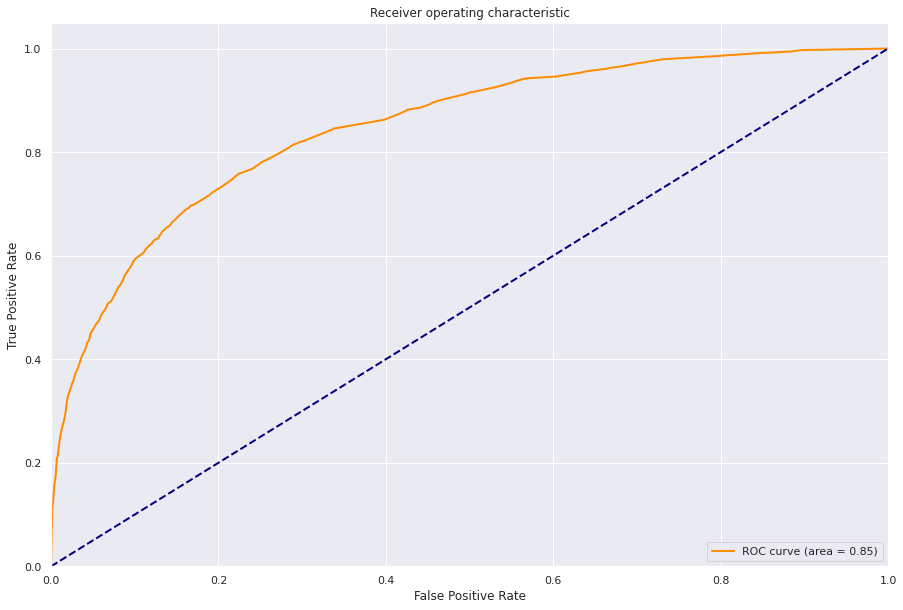

0.8469325273143424

In [12]:
fpr, tpr, thresholds = roc_curve(y_val, arbol_clasificador.predict_proba(x_val)[:, 1], pos_label="si")
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_val, arbol_clasificador.predict_proba(x_val)[:, 1]))

Para ser un modelo tan simple obtuvo una curva ROC bastante decente y un AUC score significativo.

## Predicción sobre el nuevo dataset

Realizamos la predicción sobre el nuevo dataset utilizando el preprocesamiento de transformar todas las variables a numericas.

In [13]:
nuevo_ds = obtener_prediccion_set()
ids_registro = np.array(nuevo_ds['id'])

nuevo_ds = aplicarOneHot(nuevo_ds)
nuevo_ds.drop('id', inplace=True, axis=1)

predicciones = arbol_clasificador.predict(nuevo_ds)
crear_archivo_predicciones(predicciones,"Arbol de Decision",ids_registro)